In [1]:
%matplotlib inline
from copy import deepcopy as copy
from itertools import product as c_product
import os
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h
from time_stats import xcov_with_confidence


EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'
# EXPT = 'CL_360_LOWFLOW_ACV_1'
# EXPT = 'CL_360_LOWFLOW_ACV_2'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5']

COLORS = {
    'G2': 'b', 'G3': 'r', 'G4': 'g', 'G5': 'm',
    'Motion': (1, .5, 0), 'ForVel': 'k', 'AbsAngVel': 'y', 'AbsHeading': 'c', 
}

DT = 0.1
CTL_T_OFFSET = 0  #-20

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'ODOR_TRIG')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
pulses = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'AbsHeading', 'Motion']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        if EXPT == 'CL_180_HighFlow_ACV':
            df_odor[odor_cols[1]] = 150
        df_odor[odor_cols[0]] += CTL_T_OFFSET
        df_odor[odor_cols[1]] += CTL_T_OFFSET
        
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        includes = df_odor[odor_cols[2]]
        
        for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            # add to pulse dict
            if include:
                pulses.append(
                    {'Fly': fly, 'Trial': trial, 'Pulse': ctr, 'Start': start, 'Stop': stop, 'Include': include})
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # normalize motion, for-, and angvel to median walking speed
        median_walk_speed = np.nanmedian(data_n_['Motion'][mvng_mask])
        data_n_['Motion'] /= median_walk_speed
        data_n_['ForVel'] /= median_walk_speed
        data_n_['AngVel'] /= median_walk_speed
        data_n_['AbsAngVel'] /= median_walk_speed
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)
        
df_pulse = pd.DataFrame(data=pulses, columns=['Fly', 'Trial', 'Pulse', 'Start', 'Stop', 'Include'])

n_fly = len(os.listdir(DATA_DIR))
n_trial = len(trials)
n_pulse = len(df_pulse)

print('{} FLIES, {} TRIALS, {} PULSES'.format(n_fly, n_trial, n_pulse))

26 FLIES, 48 TRIALS, 143 PULSES


# Plot trial example

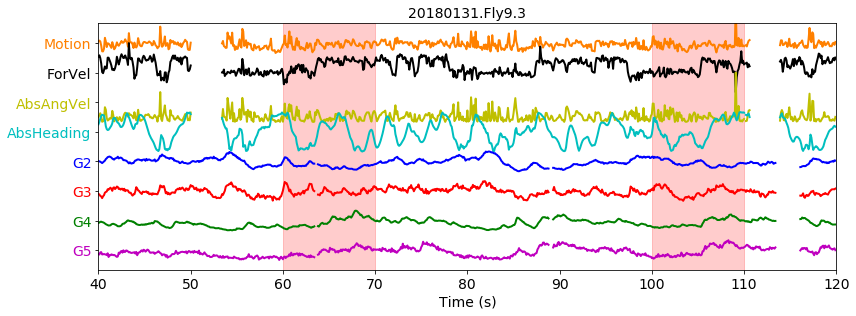

In [3]:
fig_size = (12, 4.5)
font_size = 14
trial = trials[25]
t_wdw = (40, 120)
vs = ['G2', 'G3', 'G4', 'G5']

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
t_mask = (t_wdw[0] <= t) & (t < t_wdw[1])

motion = data_n[trial]['Motion'][t_mask]
motion -= motion.min()
motion /= (.4 * motion.max())

ax.plot(t[t_mask], motion - 1.5, lw=2, c=COLORS['Motion'])

for_vel = data_n[trial]['ForVel'][t_mask]
for_vel -= for_vel.min()
for_vel /= (.4 * for_vel.max())

ax.plot(t[t_mask], for_vel - 3.5, lw=2, c=COLORS['ForVel'])

abs_ang_vel = data_n[trial]['AbsAngVel'][t_mask]
abs_ang_vel -= abs_ang_vel.min()
abs_ang_vel /= (.4 * abs_ang_vel.max())

ax.plot(t[t_mask], abs_ang_vel - 5, lw=2, c=COLORS['AbsAngVel'])

abs_heading = data_n[trial]['AbsHeading'][t_mask].copy()
abs_heading -= abs_heading.min()
abs_heading /= (.5 * abs_heading.max())

ax.plot(t[t_mask], abs_heading - 6.5, lw=2, c=COLORS['AbsHeading'])

offsets = [-1.5, -3, -4.5, -6]

for v_ctr, v in enumerate(vs):
    x = data_n[trial][v][t_mask]
    x -= x.min()
    x /= x.max()
    
    offset = -(v_ctr + 5)*1.5
    ax.plot(t[t_mask], x + offset, lw=2, c=COLORS[v])

    offsets.append(offset)
    
offsets = np.array(offsets)

df_odor = d_odor[trial]

for r_ctr, r in df_odor.iterrows():
    start = r['Odor_On']
    stop = r['Odor_Off']
    if CTL_T_OFFSET == 0:
        ax.axvspan(start, stop, color='r', alpha=0.2)
    else:
        ax.axvspan(start, stop, color='gray', alpha=0.2)
        

ax.set_xlim(t_wdw)
ax.set_ylim(-12.5, 0)
ax.set_yticks(offsets + 0.5)
ax.set_yticklabels(['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
    y_tick.set_color(COLORS[v])

ax.set_xlabel('Time (s)')
ax.set_title(trial)

set_font_size(ax, font_size)

In [4]:
T_WDW_PST = [0., 10.]
VS_PST = ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading', 'G2', 'G3', 'G4', 'G5']
LABELS = ['MTN', 'V_F', '|V_A|', '|H|', 'G2', 'G3', 'G4', 'G5']
PULSE_RANGE = [0, n_pulse]
FIG_SIZE = (15, 10)
Y_LIM = (-28, 4)
HIDE_PLOT = True

n_fig = PULSE_RANGE[1] - PULSE_RANGE[0]
gs = gridspec.GridSpec(1, 4)

odor_trig_data = {v: [] for v in ['Time'] + VS_PST}
odor_trig_corrs = {(a, b): [] for a, b in c_product(VS_PST, VS_PST)}

for p_ctr in range(n_fig):
    
    sys.stdout.write('.')
    
    fig = plt.figure(figsize=FIG_SIZE)
    axs = [fig.add_subplot(g) for g in [gs[0], gs[1:]]]
        
    trial = df_pulse.iloc[p_ctr]['Trial']
    pulse = df_pulse.iloc[p_ctr]['Pulse']
    start = df_pulse.iloc[p_ctr]['Start']
    stop = df_pulse.iloc[p_ctr]['Stop']
    t_mask = (start + T_WDW_PST[0] <= data_n[trial]['Time']) & (data_n[trial]['Time'] < start + T_WDW_PST[1])

    t = data_n[trial]['Time'][t_mask]

    odor_trig_data['Time'].append(np.array(t))

    # plot all vars
    offsets = []

    for v_ctr, v in enumerate(VS_PST):
        offset = -v_ctr*3.5
        v_vals = data_n[trial][v][t_mask].copy()

        if v in ['Motion', 'ForVel', 'AbsAngVel']:
            axs[0].axhline(offset-.5, lw=1, ls='--', alpha=1, color='k')
            axs[0].axhline(offset+.5, lw=1, ls='--', alpha=1, color='k')
            axs[0].plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)

        elif v == 'AbsHeading':
            axs[0].axhline(offset-.5, lw=.5, ls='--', alpha=1, color=COLORS[v])
            axs[0].axhline(offset+1.5, lw=.5, ls='--', alpha=1, color=COLORS[v]) 
            axs[0].plot(t, v_vals/(np.pi/2) + offset-.5, color=COLORS[v], lw=2)

        else:
            axs[0].plot(t, v_vals + offset-.5, color=COLORS[v], lw=2)
            
        odor_trig_data[v].append(np.array(v_vals))

        offsets.append(offset)

    # plot xcorrs
    tmp = []
    x_ticks = []
    for a_ctr, a in enumerate(VS_PST):
        for b_ctr, b in enumerate(VS_PST):
        
            # calc/store correlation function
            if (b, a) in tmp:
                corr_ab = copy(odor_trig_corrs[(b, a)])[-1][::-1]
            else:
                
                vals_a = copy(odor_trig_data[a][-1])
                vals_b = copy(odor_trig_data[b][-1])
                
                vals_a -= np.nanmean(vals_a)
                vals_a /= np.nanstd(vals_a)
                
                vals_b -= np.nanmean(vals_b)
                vals_b /= np.nanstd(vals_b)

                corr_ab, p_val, lb, ub = xcov_with_confidence(
                    vals_a, vals_b, int(round(len(vals_a)/2)), int(round(len(vals_b)/2)), scale=True)
                
                tmp.append((a, b))
            
            odor_trig_corrs[(a, b)].append(corr_ab)
            
            # plot xcorrs
            x_off = (1.1*len(corr_ab))*a_ctr
            y_off = -1 - 2*(b_ctr)
            
            x_0 = x_off + np.arange(int(round(len(vals_a)/2)))
            y_0 = y_off + corr_ab[:int(round(len(vals_a)/2))]
            
            x_1 = x_off + np.arange(int(round(len(vals_a)/2)), len(corr_ab))
            y_1 = y_off + corr_ab[int(round(len(vals_a)/2)):]
            
            axs[1].plot(x_0, y_0, c=COLORS[b], lw=2)
            axs[1].plot(x_1, y_1, c=COLORS[a], lw=2)

            axs[1].axhline(y_off+1, c='gray', lw=.2, ls='--')
            axs[1].axhline(y_off, c='gray', lw=.5, ls='--')
            axs[1].axhline(y_off-1, c='gray', lw=.2, ls='--')
            
        axs[1].axvline(x_off + int(round(len(vals_a)/2)), c='gray', lw=.5, ls='--')
        x_ticks.append(x_off + int(round(len(vals_a)/2)))

    if CTL_T_OFFSET:
        c_odor = 'gray'
    else:
        c_odor = 'r'

    if EXPT == 'CL_360_LOWFLOW_ACV':
        axs[0].axvspan(start, stop, color=c_odor, alpha=0.2)
    elif EXPT == 'CL_180_HighFlow_ACV':
        axs[0].axvspan(start, stop, color=c_odor, alpha=0.2)

    axs[0].set_xlim(start + T_WDW_PST[0], start + T_WDW_PST[1])
    axs[0].set_ylim(Y_LIM)

    axs[0].set_yticks(offsets)
    axs[0].set_yticklabels(LABELS)

    for y_tick, v in zip(axs[0].get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
        y_tick.set_color(COLORS[v])
        y_tick.set_fontsize(16)

    axs[1].set_xticks(x_ticks)
    axs[1].set_xticklabels(LABELS)
    
    for x_tick, v in zip(axs[1].get_xticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
        x_tick.set_color(COLORS[v])
        x_tick.set_fontsize(16)
        
    axs[1].yaxis.set_visible(False)
        
    axs[1].set_title('Auto/cross-correlations')
    axs[1].set_title('{} Pulse {}'.format(trial, pulse+1))
    
    if HIDE_PLOT:
        plt.close()
        
print('')

.

/home/rkp/Dropbox/3XPL0R/mushroom_mushroom/time_stats.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  z = 0.5 * np.log((1 + rho) / (1 - rho))  # convert to z-space
/home/rkp/Dropbox/3XPL0R/mushroom_mushroom/time_stats.py:49: RuntimeWarning: invalid value encountered in double_scalars
  lb = (np.exp(2*lb_z) - 1) / (np.exp(2*lb_z) + 1)
/home/rkp/Dropbox/3XPL0R/mushroom_mushroom/time_stats.py:50: RuntimeWarning: invalid value encountered in double_scalars
  ub = (np.exp(2*ub_z) - 1) / (np.exp(2*ub_z) + 1)


......................................................................

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/rkp/Dropbox/3XPL0R/mushroom_mushroom/time_stats.py:69: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(x_no_nans, y_no_nans)[0, 1]
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/lib/function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


........................................................................


Save

In [5]:
if CTL_T_OFFSET == 0:
    base = '{}_CORR.npy'.format(EXPT)
else:
    base = '{}_CORR_CTL.npy'.format(EXPT)
    
np.save(os.path.join(SAVE_DIR, base), np.array([{'corr': odor_trig_corrs}]))

# Statistics

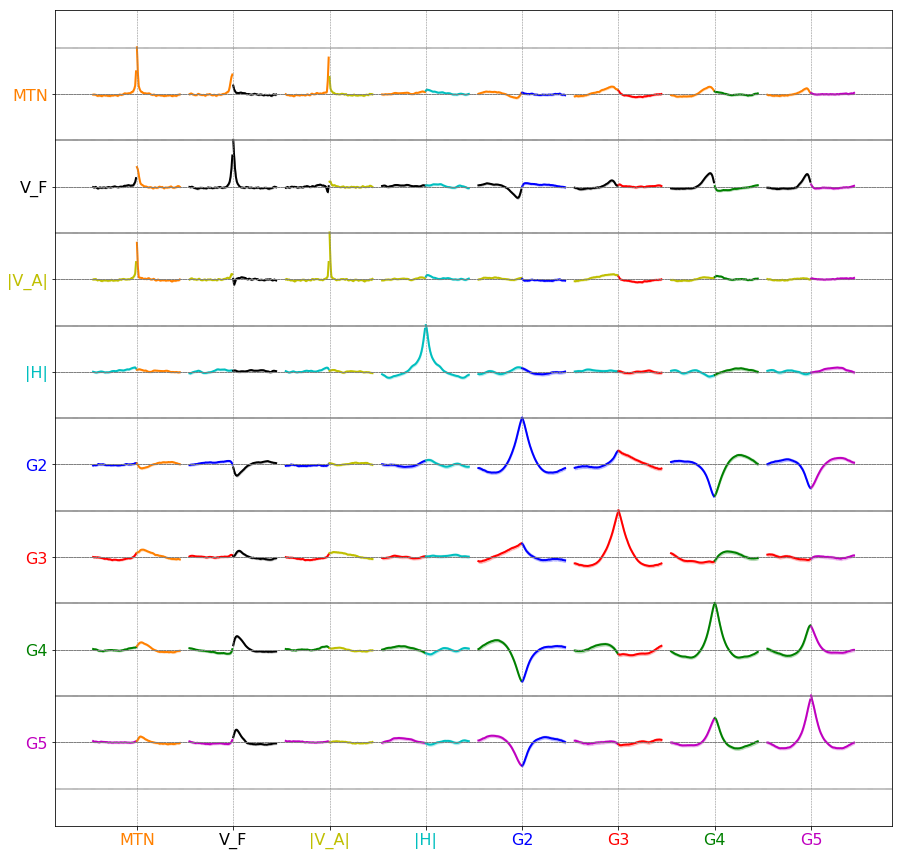

In [6]:
from aux import nansem

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
x_ticks = []
y_ticks = []
odor_trig_corr_mean = {}
odor_trig_corr_sem = {}
tmp = []
for a_ctr, a in enumerate(VS_PST):
    for b_ctr, b in enumerate(VS_PST):

        # calc/store correlation function
        if (b, a) in tmp:
            corr_ab_mean = copy(odor_trig_corr_mean[(b, a)])[::-1]
            corr_ab_sem = copy(odor_trig_corr_sem[(b, a)])[::-1]
        else:
            corrs = np.array(odor_trig_corrs[(a, b)])
            corr_ab_mean = np.nanmean(corrs, 0)
            corr_ab_sem = nansem(corrs, 0)
            
            tmp.append((a, b))

        odor_trig_corr_mean[(a, b)] = corr_ab_mean
        odor_trig_corr_sem[(a, b)] = corr_ab_sem

        # plot
        x_off = (1.1*len(corr_ab_mean))*a_ctr
        y_off = -1 - 2*(b_ctr)

        x_0 = x_off + np.arange(int(round(len(vals_a)/2)))
        y_0 = y_off + corr_ab_mean[:int(round(len(vals_a)/2))]
        err_0 = corr_ab_sem[:int(round(len(vals_a)/2))]

        x_1 = x_off + np.arange(int(round(len(vals_a)/2)), len(corr_ab))
        y_1 = y_off + corr_ab_mean[int(round(len(vals_a)/2)):]
        err_1 = corr_ab_sem[int(round(len(vals_a)/2)):]

        ax.plot(x_0, y_0, c=COLORS[b], lw=2)
        ax.plot(x_1, y_1, c=COLORS[a], lw=2)
        
        ax.fill_between(x_0, y_0-err_0, y_0+err_0, color=COLORS[b], alpha=0.2)
        ax.fill_between(x_1, y_1-err_1, y_1+err_1, color=COLORS[a], alpha=0.2)

        ax.axhline(y_off+1, c='gray', lw=.2, ls='--')
        ax.axhline(y_off, c='gray', lw=.5, ls='--')
        ax.axhline(y_off-1, c='gray', lw=.2, ls='--')
        
        if a_ctr == 0:
            y_ticks.append(y_off)

    ax.axvline(x_off + int(round(len(vals_a)/2)), c='gray', lw=.5, ls='--')
    x_ticks.append(x_off + int(round(len(vals_a)/2)))
    
ax.set_yticks(y_ticks)
ax.set_yticklabels(LABELS)

for y_tick, v in zip(ax.get_yticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
    y_tick.set_color(COLORS[v])
    y_tick.set_fontsize(16)

ax.set_xticks(x_ticks)
ax.set_xticklabels(LABELS)

for x_tick, v in zip(ax.get_xticklabels(), ['Motion', 'ForVel', 'AbsAngVel', 'AbsHeading'] + vs):
    x_tick.set_color(COLORS[v])
    x_tick.set_fontsize(16)

# Comparison

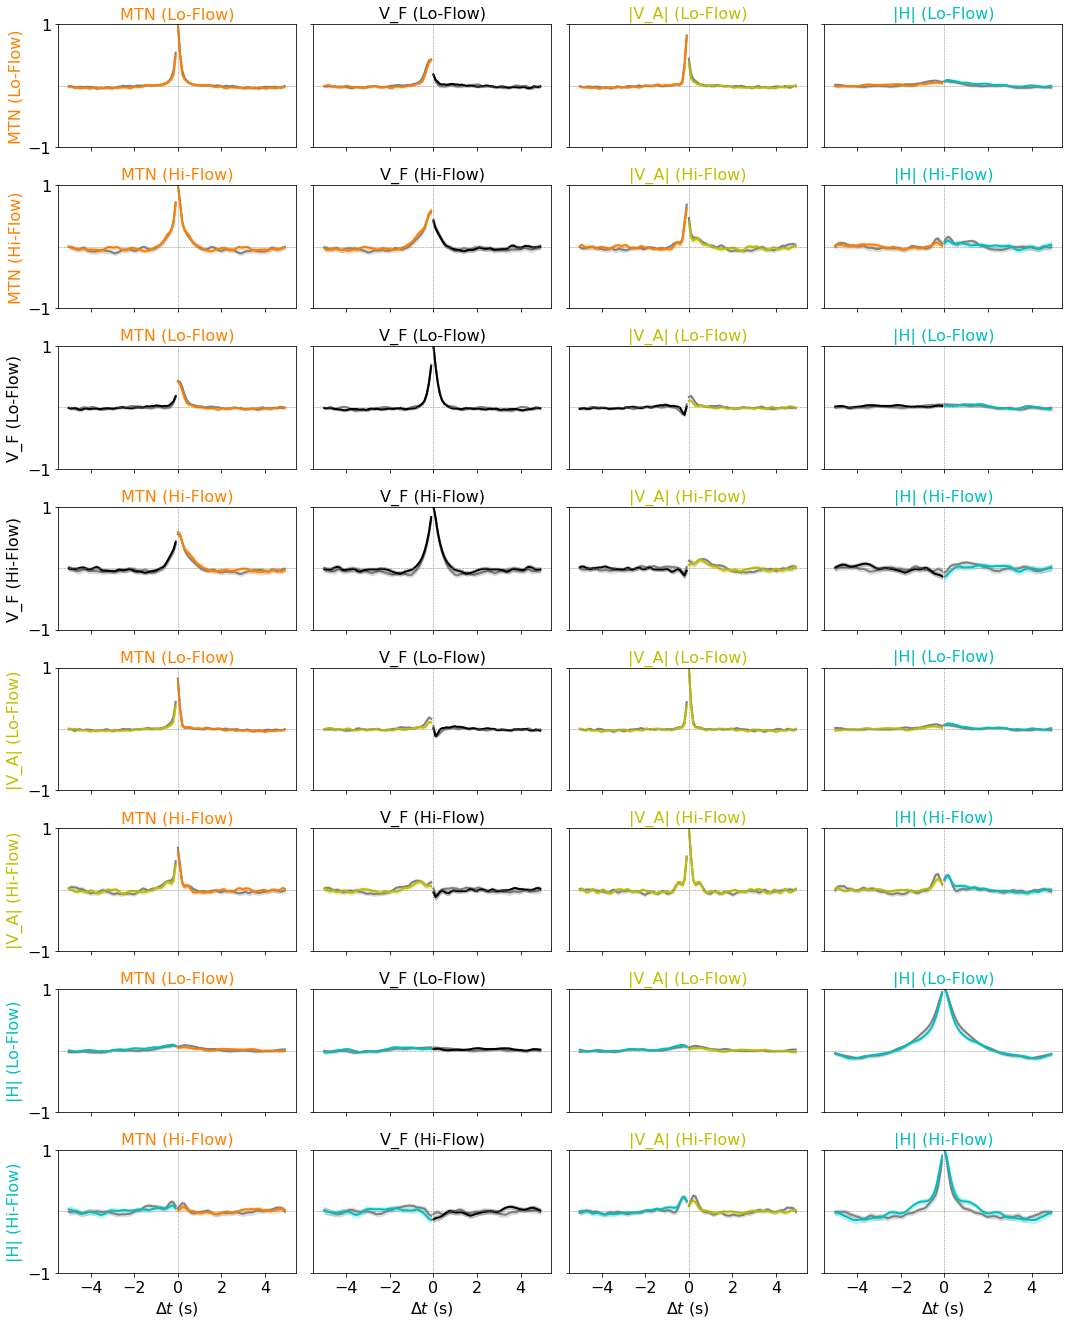

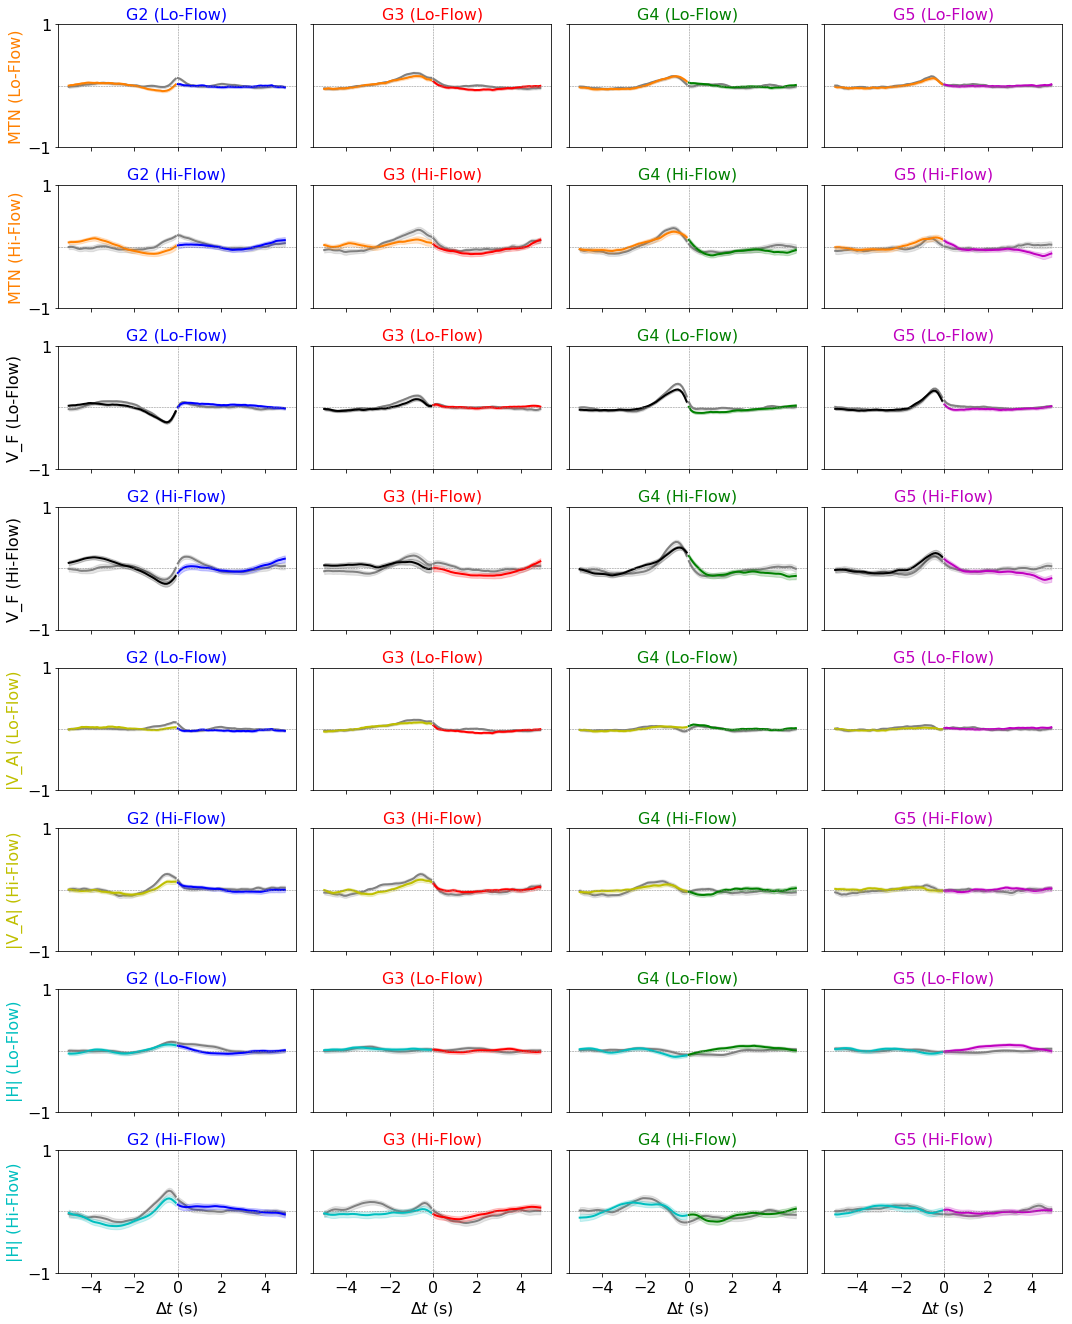

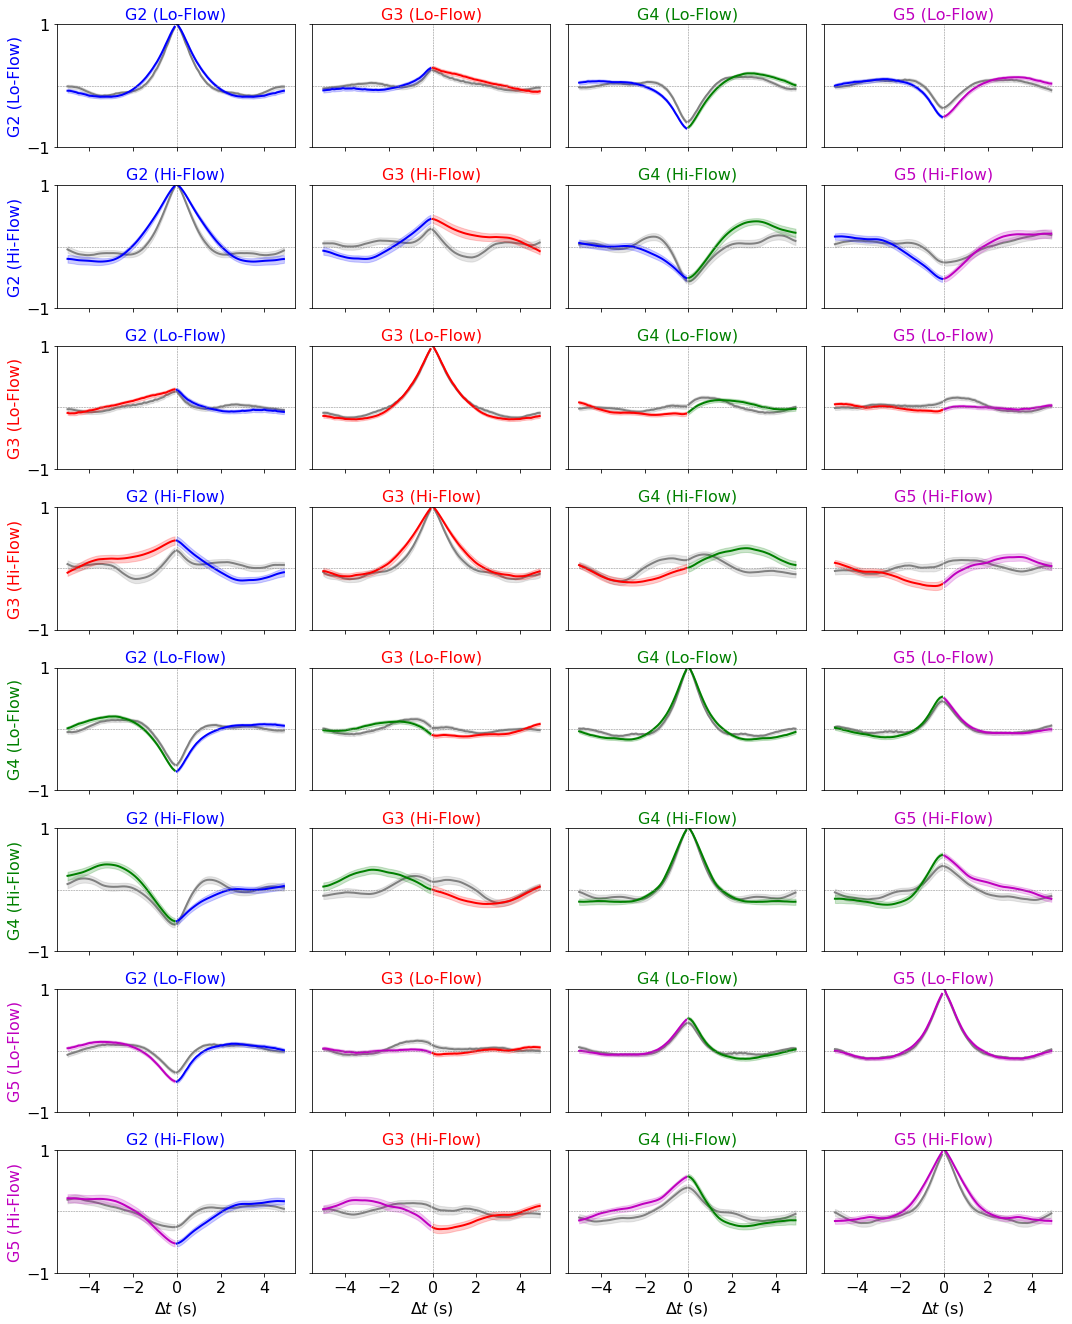

In [7]:
EXPTS = ['CL_360_LOWFLOW_ACV', 'CL_180_HighFlow_ACV']
EXPT_LABELS = ['Lo-Flow', 'Hi-Flow']
SFXS = ['CORR.npy', 'CORR_CTL.npy']
Y_LIM = {
    'Motion': (0, 1.5), 'ForVel': (0, 1.5), 'AbsAngVel': (0, 1.5), 'AbsHeading': (0, np.pi/2),
    'G2': (-2, 2), 'G3': (-2, 2), 'G4': (-2, 2), 'G5': (-2, 2),
}
V_LABELS ={
    'Motion': 'MTN', 'ForVel': 'V_F', 'AbsAngVel': '|V_A|', 'AbsHeading': '|H|',
    'G2': 'G2', 'G3': 'G3', 'G4': 'G4', 'G5': 'G5',
}

for V_B, V_A in [(VS_PST[:4], VS_PST[:4]), (VS_PST[:4], VS_PST[4:]), (VS_PST[4:], VS_PST[4:])]:

    fig, axs = plt.subplots(8, 4, figsize=(15, 18.5), sharex=True, sharey=True, tight_layout=True)
    axs = [axs[[0, 2, 4, 6], :], axs[[1, 3, 5, 7], :]]

    for expt, expt_label, axs_ in zip(EXPTS, EXPT_LABELS, axs):
        for sfx in SFXS:

            # load data
            odor_trig_corrs = np.load(os.path.join(SAVE_DIR, '{}_{}'.format(expt, sfx)))[0]['corr']

            for a_ctr, a in enumerate(V_A):
                for b_ctr, b in enumerate(V_B):

                    ax = axs_[b_ctr, a_ctr]

                    # get cross-corrs mean & sem
                    corrs_ab = np.array(odor_trig_corrs[(a, b)])
                    corr_ab_mean = np.nanmean(corrs_ab, 0)
                    corr_ab_sem = nansem(corrs_ab, 0)

                    # plot
                    x_0 = np.arange(-int(round(len(corr_ab_mean)/2)), 0)*DT
                    y_0 = corr_ab_mean[:int(round(len(corr_ab_mean)/2))]
                    err_0 = corr_ab_sem[:int(round(len(corr_ab_mean)/2))]

                    x_1 = np.arange(0, len(corr_ab_mean) - int(round(len(corr_ab_mean)/2)))*DT
                    y_1 = corr_ab_mean[int(round(len(corr_ab_mean)/2)):]
                    err_1 = corr_ab_sem[int(round(len(corr_ab_mean)/2)):]

                    if sfx == SFXS[0]:
                        ax.plot(x_0, y_0, c=COLORS[b], lw=2, zorder=1)
                        ax.plot(x_1, y_1, c=COLORS[a], lw=2, zorder=1)

                        ax.fill_between(x_0, y_0-err_0, y_0+err_0, color=COLORS[b], alpha=0.2, zorder=1)
                        ax.fill_between(x_1, y_1-err_1, y_1+err_1, color=COLORS[a], alpha=0.2, zorder=1)

                    else:
                        ax.plot(x_0, y_0, c='gray', lw=2, zorder=-1)
                        ax.plot(x_1, y_1, c='gray', lw=2, zorder=-1)

                        ax.fill_between(x_0, y_0-err_0, y_0+err_0, color='gray', alpha=0.2, zorder=-1)
                        ax.fill_between(x_1, y_1-err_1, y_1+err_1, color='gray', alpha=0.2, zorder=-1)

                        ax.axhline(0, c='gray', lw=.5, ls='--')
                        ax.axvline(0, c='gray', lw=.5, ls='--')

                        ax.set_ylim(-1, 1)
                        ax.set_title('{} ({})'.format(V_LABELS[a], expt_label), color=COLORS[a])
                        
                        if a == V_A[0]:
                            ax.set_yticks([-1, 1])
                            ax.set_ylabel('{} ({})'.format(V_LABELS[b], expt_label), color=COLORS[b])
                            
                        if b == V_B[-1] and expt == EXPTS[-1]:
                            ax.set_xlabel(r'$\Delta t$ (s)')
                            
        for ax in axs_.flatten():
            set_font_size(ax, 16)